In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import PIL.Image
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.nn import init
from matplotlib import pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

if not os.path.isdir('targetdir/'):

  with zipfile.ZipFile("drive/MyDrive/SynthOldPhotos.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

  with zipfile.ZipFile("/content/drive/MyDrive/OldRealPhotos.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

Une vraie vieille photo du dataset OldRealPhotos


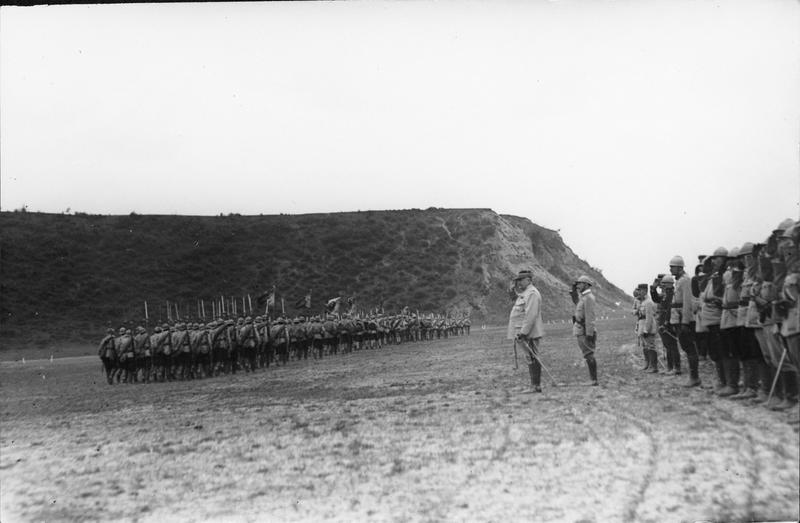



Vieille photo créée artificiellement du dataset SynthOldPhotos


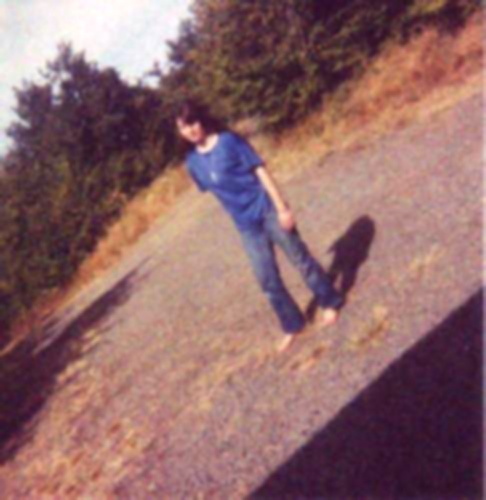

In [ ]:
from IPython.display import Image, display

print("Une vraie vieille photo du dataset OldRealPhotos")
display(Image('targetdir/OldRealPhotos/photo_1023.jpg', width = 350, height = 350))

print("\n\nVieille photo créée artificiellement du dataset SynthOldPhotos")
display(Image('targetdir/SynthOldPhotos/2007_000027.jpg', width = 350, height = 350))

In [ ]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 256, 256)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 256, 256)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

## Data Generator

In [ ]:
real_path = "/content/targetdir/OldRealPhotos/"
x_path = "/content/targetdir/SynthOldPhotos/"
batch_size = 16 

class FakeAndRealOldPhotosGenerator(Dataset):
    def __init__(self, path_r,path_x):
        self.files_r = [os.path.join(path_r, f) for f in os.listdir(path_r)]
        self.files_x = [os.path.join(path_x, f) for f in os.listdir(path_x)]

    def __getitem__(self, index):
        img_r=self.read_image(self.files_r[index])
        img_x=self.read_image(self.files_x[index])
        return img_r, img_x

    def read_image(self,name):
        img = PIL.Image.open(name).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img) / 255.0
        img = np.transpose(img, (2,0,1)).astype('float32')
        return torch.tensor(img-0.5)

    def __len__(self):
      return min([len(self.files_r), len(self.files_x)]) 

data_set = FakeAndRealOldPhotosGenerator(real_path, x_path)

train_len = int(len(data_set)*0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=5)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=5)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1, padding=1)
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out


class ConvBNR(nn.Module):
  def __init__(self, in_channels, out_channels, activation=nn.LeakyReLU(0.2, False), kw=3, strides=2, pad=1):
        super(ConvBNR, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides, padding=pad)
        self.bn1 = nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation

  def forward(self, x):
        return self.bn1(self.conv1(self.activation(x)))


class TransposeConvBNR(nn.Module):
  def __init__(self, in_channels, out_channels, activation=nn.LeakyReLU(0.2, False), kw=4, strides=2, pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides, padding=pad)
        self.bn1 = nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation

  def forward(self, x):
        return self.bn1(self.conv1(self.activation(x)))


class VAE1_encoder(nn.Module):
    def __init__(self, in_channels=3, n_res_blocks=4, n_layers=5):
        super(VAE1_encoder, self).__init__()
        self.n_layers = n_layers
        self.layer = nn.ModuleList()
        self.layer1 = ConvBNR(in_channels, 64, kw=7, pad=3, strides=1)
        for j in range(n_layers):
            self.layer.append(ConvBNR(64, 64))

        self.res_blks = nn.ModuleList()
        self.n_res_blocks = n_res_blocks
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64, 64))

    def forward(self, x):
        x=self.layer1(x)
        for j in range(self.n_layers):
          x= self.layer[j](x)

        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x)
        return x


class VAE1_decoder(nn.Module):
    def __init__(self, in_channels=64, out_channel=3, n_res_blocks=4, n_layers=5):
        super(VAE1_decoder, self).__init__()
        self.n_layers = n_layers
        self.layer = nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64, 64, pad=1))

        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1)
        self.res_blks = nn.ModuleList()
        self.n_res_blocks = n_res_blocks
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64, 64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x = self.res_blks[j](x)
        
        for j in range(self.n_layers):
            x = self.layer[j](x)

        x = self.layer1(x)
        return x


class VAE1(nn.Module):
  def __init__(self, z_dim=256):
        super(VAE1, self).__init__()
        self.n_layers = 2
        self.down_fact = 2**self.n_layers
        down_img_size = 256 // self.down_fact
        self.fdim = (down_img_size)**2 * 64
        self.size=[64, down_img_size, down_img_size]
        self.encoder = VAE1_encoder(n_layers=self.n_layers)
        self.decoder = VAE1_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)

  def flat(self, input):
        return input.view(input.size(0), 1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar = logvar * 1e-3 #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h = self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img = self.unflat(z)
      z = self.decoder(z_img)
      return z, z_img

  def forward(self, x, flow='all'):
      z_latent, mu, logvar = self.encode(x)
      z,z_out = self.decode(z_latent)
      if(flow == 'all'):
        return z, mu, logvar,z_out
      else:
        return z, mu, logvar,z_out,z_latent

bottle neck image resolution 64
bottle neck dim is 262144..!
torch.Size([10, 1, 256])


In [ ]:
#LSGAN
class ConvBNRelu(nn.Module):
    def __init__(self, nin,nout,stride=2):
        super(ConvBNRelu, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(nin, nout, kernel_size=4, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(nout),
            nn.LeakyReLU(0.2, inplace=True)
            )
        
    def forward(self, x):
        return self.layer(x)


class Discriminator(nn.Module):
    def __init__(self,nChannels=64, ndf=64):
        super(Discriminator, self).__init__()
        self.layer1 = ConvBNRelu(nChannels, ndf, stride=2)
        self.layer2 =  ConvBNRelu(ndf, ndf*2, stride=2)
        self.layer3 =  ConvBNRelu(ndf*2, ndf*4, stride=2)
        self.layer4 =  ConvBNRelu(ndf*4 ,ndf*8, stride=2)
        self.layer5 =   ConvBNRelu(ndf*8, 1, stride=1)
        self.final = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.final(out)
        return out


model = Discriminator(nChannels=64,ndf=64).to(device)
z=model(torch.ones((1,64,64,64)).to(device))

torch.Size([1, 1, 3, 3])


bottle neck image resolution 64
bottle neck dim is 262144..!
..starting the training


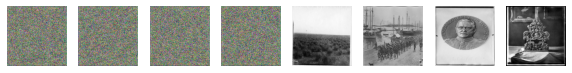

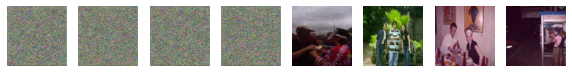

====> Test set loss_r: 0.0318 test loss_x: 0.0313
====> Epoch: 1 Average discriminator loss: 0.0230 Generator loss: 7.7068
====> Test set loss_r: 0.0147 test loss_x: 0.0131
====> Epoch: 2 Average discriminator loss: 0.0183 Generator loss: 6.8893
====> Test set loss_r: 0.0145 test loss_x: 0.0122
====> Epoch: 3 Average discriminator loss: 0.0174 Generator loss: 6.7252
====> Test set loss_r: 0.0159 test loss_x: 0.0122
====> Epoch: 4 Average discriminator loss: 0.0167 Generator loss: 6.5558
====> Test set loss_r: 0.0150 test loss_x: 0.0109
====> Epoch: 5 Average discriminator loss: 0.0166 Generator loss: 6.4109


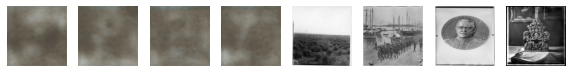

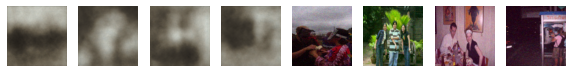

====> Test set loss_r: 0.0156 test loss_x: 0.0108
====> Epoch: 6 Average discriminator loss: 0.0162 Generator loss: 6.2666
====> Test set loss_r: 0.0159 test loss_x: 0.0109
====> Epoch: 7 Average discriminator loss: 0.0156 Generator loss: 6.1731
====> Test set loss_r: 0.0159 test loss_x: 0.0112
====> Epoch: 8 Average discriminator loss: 0.0152 Generator loss: 6.0695
====> Test set loss_r: 0.0161 test loss_x: 0.0109
====> Epoch: 9 Average discriminator loss: 0.0148 Generator loss: 5.9641
====> Test set loss_r: 0.0168 test loss_x: 0.0109
====> Epoch: 10 Average discriminator loss: 0.0145 Generator loss: 5.8690


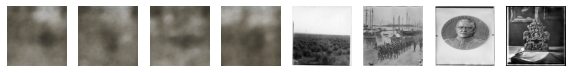

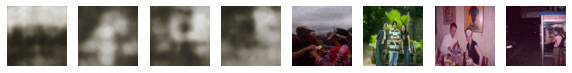

====> Test set loss_r: 0.0161 test loss_x: 0.0108
====> Epoch: 11 Average discriminator loss: 0.0143 Generator loss: 5.7578
====> Test set loss_r: 0.0165 test loss_x: 0.0107
====> Epoch: 12 Average discriminator loss: 0.0141 Generator loss: 5.6586
====> Test set loss_r: 0.0163 test loss_x: 0.0105
====> Epoch: 13 Average discriminator loss: 0.0140 Generator loss: 5.5746
====> Test set loss_r: 0.0166 test loss_x: 0.0105
====> Epoch: 14 Average discriminator loss: 0.0138 Generator loss: 5.4907
====> Test set loss_r: 0.0162 test loss_x: 0.0105
====> Epoch: 15 Average discriminator loss: 0.0137 Generator loss: 5.3908


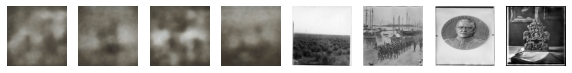

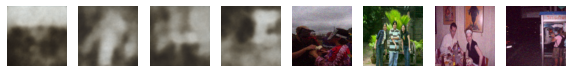

====> Test set loss_r: 0.0169 test loss_x: 0.0105
====> Epoch: 16 Average discriminator loss: 0.0136 Generator loss: 5.3379
====> Test set loss_r: 0.0170 test loss_x: 0.0105
====> Epoch: 17 Average discriminator loss: 0.0136 Generator loss: 5.2547
====> Test set loss_r: 0.0172 test loss_x: 0.0104
====> Epoch: 18 Average discriminator loss: 0.0135 Generator loss: 5.1927
====> Test set loss_r: 0.0160 test loss_x: 0.0102
====> Epoch: 19 Average discriminator loss: 0.0136 Generator loss: 5.1672
====> Test set loss_r: 0.0163 test loss_x: 0.0105
====> Epoch: 20 Average discriminator loss: 0.0135 Generator loss: 5.1146


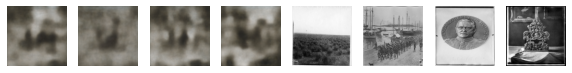

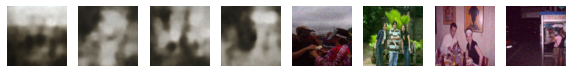

====> Test set loss_r: 0.0167 test loss_x: 0.0105
====> Epoch: 21 Average discriminator loss: 0.0134 Generator loss: 5.0614
====> Test set loss_r: 0.0163 test loss_x: 0.0103
====> Epoch: 22 Average discriminator loss: 0.0132 Generator loss: 5.0275
====> Test set loss_r: 0.0166 test loss_x: 0.0103
====> Epoch: 23 Average discriminator loss: 0.0132 Generator loss: 4.9844
====> Test set loss_r: 0.0166 test loss_x: 0.0104
====> Epoch: 24 Average discriminator loss: 0.0133 Generator loss: 4.9439
====> Test set loss_r: 0.0161 test loss_x: 0.0104
====> Epoch: 25 Average discriminator loss: 0.0135 Generator loss: 4.9218


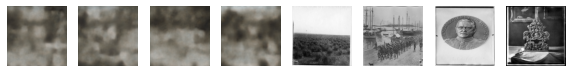

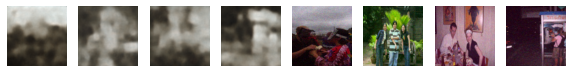

====> Test set loss_r: 0.0171 test loss_x: 0.0105
====> Epoch: 26 Average discriminator loss: 0.0134 Generator loss: 4.9177
====> Test set loss_r: 0.0163 test loss_x: 0.0104
====> Epoch: 27 Average discriminator loss: 0.0133 Generator loss: 4.8694
====> Test set loss_r: 0.0162 test loss_x: 0.0105
====> Epoch: 28 Average discriminator loss: 0.0134 Generator loss: 4.8733
====> Test set loss_r: 0.0169 test loss_x: 0.0119
====> Epoch: 29 Average discriminator loss: 0.0133 Generator loss: 4.8293
====> Test set loss_r: 0.0160 test loss_x: 0.0104
====> Epoch: 30 Average discriminator loss: 0.0131 Generator loss: 4.7676


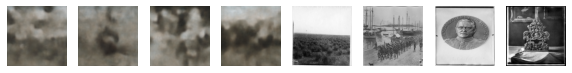

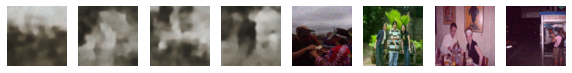

====> Test set loss_r: 0.0160 test loss_x: 0.0105
====> Epoch: 31 Average discriminator loss: 0.0131 Generator loss: 4.7371
====> Test set loss_r: 0.0166 test loss_x: 0.0106
====> Epoch: 32 Average discriminator loss: 0.0130 Generator loss: 4.7347
====> Test set loss_r: 0.0164 test loss_x: 0.0105
====> Epoch: 33 Average discriminator loss: 0.0133 Generator loss: 4.7987
====> Test set loss_r: 0.0165 test loss_x: 0.0104
====> Epoch: 34 Average discriminator loss: 0.0133 Generator loss: 4.7069
====> Test set loss_r: 0.0164 test loss_x: 0.0106
====> Epoch: 35 Average discriminator loss: 0.0133 Generator loss: 4.6696


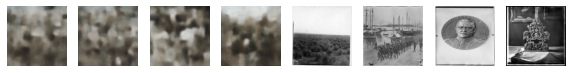

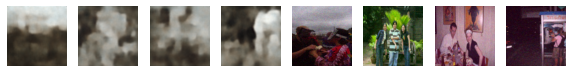

====> Test set loss_r: 0.0168 test loss_x: 0.0106
====> Epoch: 36 Average discriminator loss: 0.0135 Generator loss: 4.6514
====> Test set loss_r: 0.0165 test loss_x: 0.0106
====> Epoch: 37 Average discriminator loss: 0.0135 Generator loss: 4.6258
====> Test set loss_r: 0.0165 test loss_x: 0.0105
====> Epoch: 38 Average discriminator loss: 0.0135 Generator loss: 4.6732
====> Test set loss_r: 0.0168 test loss_x: 0.0105
====> Epoch: 39 Average discriminator loss: 0.0133 Generator loss: 4.6632
====> Test set loss_r: 0.0167 test loss_x: 0.0107
====> Epoch: 40 Average discriminator loss: 0.0132 Generator loss: 4.5854


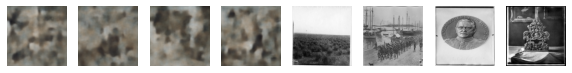

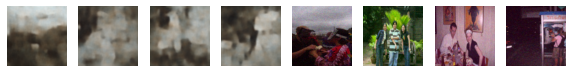

====> Test set loss_r: 0.0166 test loss_x: 0.0107
====> Epoch: 41 Average discriminator loss: 0.0131 Generator loss: 4.5628
====> Test set loss_r: 0.0161 test loss_x: 0.0106
====> Epoch: 42 Average discriminator loss: 0.0134 Generator loss: 4.5558
====> Test set loss_r: 0.0163 test loss_x: 0.0108
====> Epoch: 43 Average discriminator loss: 0.0131 Generator loss: 4.5282
====> Test set loss_r: 0.0166 test loss_x: 0.0107
====> Epoch: 44 Average discriminator loss: 0.0132 Generator loss: 4.5121
====> Test set loss_r: 0.0166 test loss_x: 0.0109
====> Epoch: 45 Average discriminator loss: 0.0133 Generator loss: 4.6062


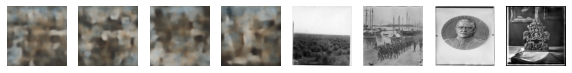

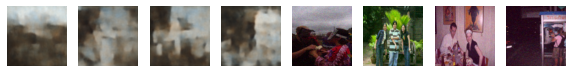

====> Test set loss_r: 0.0165 test loss_x: 0.0106
====> Epoch: 46 Average discriminator loss: 0.0134 Generator loss: 4.4981
====> Test set loss_r: 0.0164 test loss_x: 0.0107
====> Epoch: 47 Average discriminator loss: 0.0132 Generator loss: 4.4728
====> Test set loss_r: 0.0164 test loss_x: 0.0106
====> Epoch: 48 Average discriminator loss: 0.0131 Generator loss: 4.4778
====> Test set loss_r: 0.0165 test loss_x: 0.0109
====> Epoch: 49 Average discriminator loss: 0.0131 Generator loss: 4.5081
====> Test set loss_r: 0.0168 test loss_x: 0.0108
====> Epoch: 50 Average discriminator loss: 0.0130 Generator loss: 4.4206


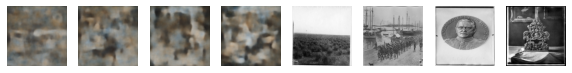

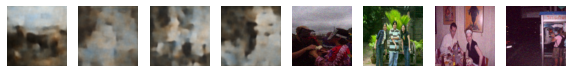

====> Test set loss_r: 0.0166 test loss_x: 0.0109
====> Epoch: 51 Average discriminator loss: 0.0134 Generator loss: 4.4022
====> Test set loss_r: 0.0168 test loss_x: 0.0108
====> Epoch: 52 Average discriminator loss: 0.0137 Generator loss: 4.4587
====> Test set loss_r: 0.0169 test loss_x: 0.0110
====> Epoch: 53 Average discriminator loss: 0.0136 Generator loss: 4.4662
====> Test set loss_r: 0.0166 test loss_x: 0.0111
====> Epoch: 54 Average discriminator loss: 0.0132 Generator loss: 4.3766
====> Test set loss_r: 0.0169 test loss_x: 0.0111
====> Epoch: 55 Average discriminator loss: 0.0132 Generator loss: 4.3425


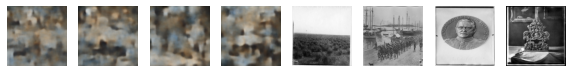

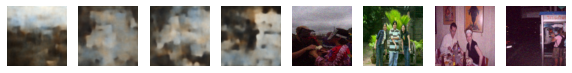

====> Test set loss_r: 0.0168 test loss_x: 0.0110
====> Epoch: 56 Average discriminator loss: 0.0133 Generator loss: 4.3404
====> Test set loss_r: 0.0165 test loss_x: 0.0111
====> Epoch: 57 Average discriminator loss: 0.0133 Generator loss: 4.3201
====> Test set loss_r: 0.0164 test loss_x: 0.0110
====> Epoch: 58 Average discriminator loss: 0.0133 Generator loss: 4.5326
====> Test set loss_r: 0.0164 test loss_x: 0.0110
====> Epoch: 59 Average discriminator loss: 0.0131 Generator loss: 4.3035
====> Test set loss_r: 0.0166 test loss_x: 0.0111
====> Epoch: 60 Average discriminator loss: 0.0132 Generator loss: 4.2744


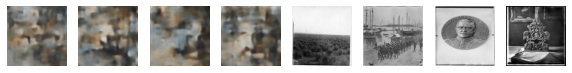

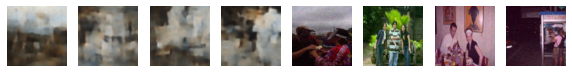

====> Test set loss_r: 0.0165 test loss_x: 0.0111
====> Epoch: 61 Average discriminator loss: 0.0136 Generator loss: 4.2561
====> Test set loss_r: 0.0162 test loss_x: 0.0111
====> Epoch: 62 Average discriminator loss: 0.0134 Generator loss: 4.2427
====> Test set loss_r: 0.0163 test loss_x: 0.0111
====> Epoch: 63 Average discriminator loss: 0.0136 Generator loss: 4.2362
====> Test set loss_r: 0.0166 test loss_x: 0.0115
====> Epoch: 64 Average discriminator loss: 0.0136 Generator loss: 4.3105
====> Test set loss_r: 0.0166 test loss_x: 0.0113
====> Epoch: 65 Average discriminator loss: 0.0135 Generator loss: 4.2927


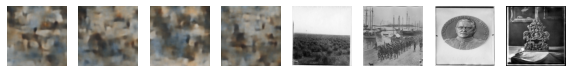

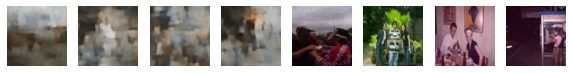

====> Test set loss_r: 0.0163 test loss_x: 0.0112
====> Epoch: 66 Average discriminator loss: 0.0136 Generator loss: 4.2100
====> Test set loss_r: 0.0161 test loss_x: 0.0111
====> Epoch: 67 Average discriminator loss: 0.0134 Generator loss: 4.1942
====> Test set loss_r: 0.0165 test loss_x: 0.0113
====> Epoch: 68 Average discriminator loss: 0.0133 Generator loss: 4.1879
====> Test set loss_r: 0.0163 test loss_x: 0.0110
====> Epoch: 69 Average discriminator loss: 0.0136 Generator loss: 4.2699
====> Test set loss_r: 0.0164 test loss_x: 0.0113
====> Epoch: 70 Average discriminator loss: 0.0135 Generator loss: 4.1988


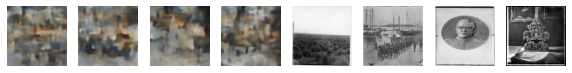

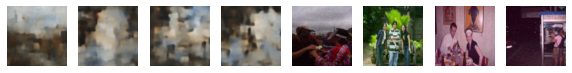

====> Test set loss_r: 0.0165 test loss_x: 0.0111
====> Epoch: 71 Average discriminator loss: 0.0135 Generator loss: 4.1646
====> Test set loss_r: 0.0167 test loss_x: 0.0112
====> Epoch: 72 Average discriminator loss: 0.0136 Generator loss: 4.2512
====> Test set loss_r: 0.0164 test loss_x: 0.0111
====> Epoch: 73 Average discriminator loss: 0.0136 Generator loss: 4.2320
====> Test set loss_r: 0.0165 test loss_x: 0.0113
====> Epoch: 74 Average discriminator loss: 0.0135 Generator loss: 4.1369
====> Test set loss_r: 0.0167 test loss_x: 0.0114
====> Epoch: 75 Average discriminator loss: 0.0135 Generator loss: 4.1253


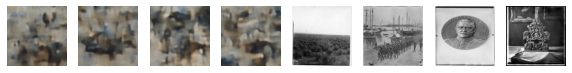

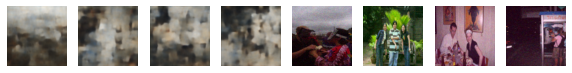

====> Test set loss_r: 0.0166 test loss_x: 0.0113
====> Epoch: 76 Average discriminator loss: 0.0136 Generator loss: 4.1659
====> Test set loss_r: 0.0163 test loss_x: 0.0112
====> Epoch: 77 Average discriminator loss: 0.0136 Generator loss: 4.1089
====> Test set loss_r: 0.0163 test loss_x: 0.0115
====> Epoch: 78 Average discriminator loss: 0.0135 Generator loss: 4.1045
====> Test set loss_r: 0.0167 test loss_x: 0.0115
====> Epoch: 79 Average discriminator loss: 0.0136 Generator loss: 4.1154
====> Epoch: 80 Average discriminator loss: 0.0137 Generator loss: 4.0972


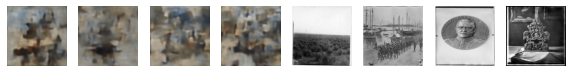

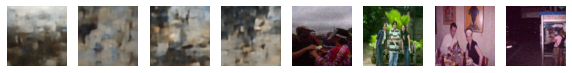

====> Test set loss_r: 0.0167 test loss_x: 0.0115
====> Epoch: 81 Average discriminator loss: 0.0139 Generator loss: 4.2677
====> Test set loss_r: 0.0182 test loss_x: 0.0132
====> Epoch: 82 Average discriminator loss: 0.0137 Generator loss: 4.1709
====> Test set loss_r: 0.0163 test loss_x: 0.0113
====> Epoch: 83 Average discriminator loss: 0.0138 Generator loss: 4.1050
====> Test set loss_r: 0.0168 test loss_x: 0.0116
====> Epoch: 84 Average discriminator loss: 0.0138 Generator loss: 4.1428
====> Test set loss_r: 0.0166 test loss_x: 0.0114
====> Epoch: 85 Average discriminator loss: 0.0136 Generator loss: 4.0615


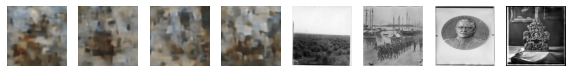

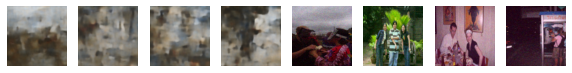

====> Test set loss_r: 0.0165 test loss_x: 0.0113
====> Epoch: 86 Average discriminator loss: 0.0138 Generator loss: 4.0408
====> Test set loss_r: 0.0169 test loss_x: 0.0116
====> Epoch: 87 Average discriminator loss: 0.0138 Generator loss: 4.0311
====> Test set loss_r: 0.0168 test loss_x: 0.0116
====> Epoch: 88 Average discriminator loss: 0.0140 Generator loss: 4.1712
====> Test set loss_r: 0.0167 test loss_x: 0.0116
====> Epoch: 89 Average discriminator loss: 0.0139 Generator loss: 4.0418
====> Test set loss_r: 0.0169 test loss_x: 0.0117
====> Epoch: 90 Average discriminator loss: 0.0140 Generator loss: 4.0244


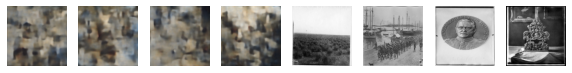

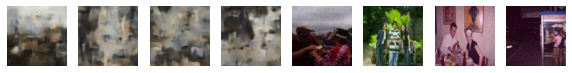

====> Test set loss_r: 0.0169 test loss_x: 0.0118
====> Epoch: 91 Average discriminator loss: 0.0141 Generator loss: 4.0138
====> Test set loss_r: 0.0167 test loss_x: 0.0116
====> Epoch: 92 Average discriminator loss: 0.0144 Generator loss: 4.1559
====> Test set loss_r: 0.0165 test loss_x: 0.0117
====> Epoch: 93 Average discriminator loss: 0.0141 Generator loss: 4.0303
====> Test set loss_r: 0.0169 test loss_x: 0.0117
====> Epoch: 94 Average discriminator loss: 0.0142 Generator loss: 4.0053
====> Test set loss_r: 0.0166 test loss_x: 0.0116
====> Epoch: 95 Average discriminator loss: 0.0142 Generator loss: 3.9894


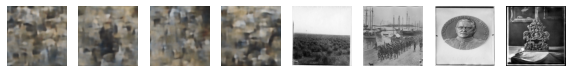

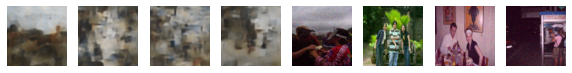

====> Test set loss_r: 0.0165 test loss_x: 0.0117
====> Epoch: 96 Average discriminator loss: 0.0144 Generator loss: 4.5180
====> Test set loss_r: 0.0166 test loss_x: 0.0116
====> Epoch: 97 Average discriminator loss: 0.0141 Generator loss: 4.0071
====> Test set loss_r: 0.0165 test loss_x: 0.0115
====> Epoch: 98 Average discriminator loss: 0.0145 Generator loss: 3.9817
====> Test set loss_r: 0.0168 test loss_x: 0.0117
====> Epoch: 99 Average discriminator loss: 0.0144 Generator loss: 3.9628
====> Test set loss_r: 0.0170 test loss_x: 0.0118
====> Epoch: 100 Average discriminator loss: 0.0144 Generator loss: 3.9623


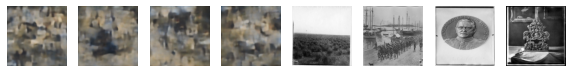

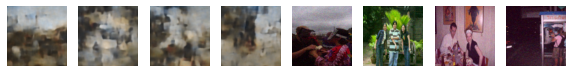

====> Test set loss_r: 0.0168 test loss_x: 0.0117


In [ ]:
learning_rate = 1e-4
epochs = 100

netG = VAE1().to(device)
netD = Discriminator(nChannels=64, ndf=64).to(device)
l1_loss=torch.nn.L1Loss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))

means, logvars, costs = [], [], []

for epoch in range(0, epochs + 1):

    # Training
    if epoch > 0:  # test untrained net first
        netG.train()
        netD.train()
        train_lossG = 0.
        train_lossD = 0.

        for  samp_real,samp_x in train_loader:

            samp_real = samp_real.to(device)
            samp_x = samp_x.to(device)

            x_hat_real, mu_real, logvar_real, z_real = netG(samp_real)
            x_hat_x, mu_x, logvar_x, z_x = netG(samp_x)

            out_r = netD(z_real.detach())
            out_x = netD(z_x.detach())
            lossD = 0.5 *(torch.mean((1.0 - out_r)**2) + torch.mean((out_x)**2))
            train_lossD += lossD.item()

            optimizerD.zero_grad()
            lossD.backward()
            optimizerD.step()

            loss_real_l1 = l1_loss(x_hat_real, samp_x) * 256.0
            loss_real_kl = 0.5 * torch.mean(logvar_real.exp() - logvar_real - 1.0 + mu_real**2)
            loss_real = loss_real_l1 + loss_real_kl

            loss_x_l1 = l1_loss(x_hat_x, samp_x) * 256.0
            loss_x_kl = 0.5 * torch.mean(logvar_x.exp() - logvar_x - 1.0 + mu_x**2)
            loss_x = loss_x_l1 + loss_x_kl   

            out_r = netD(z_real)
            out_x = netD(z_x)
            lossGAN = 0.5 * (torch.mean(out_r**2) + torch.mean((1.0 - out_x)**2))

            lossF= loss_real + loss_x + lossGAN #Total loss
            train_lossG += lossF.item()

            optimizerG.zero_grad()
            lossF.backward()
            optimizerG.step()
            costs.append([loss_real.item(), loss_x.item(), lossGAN.item(), lossD.item()])

        print(f'====> Epoch: {epoch} Average discriminator loss: {train_lossD / len(train_loader.dataset):.4f} Generator loss: {train_lossG / len(train_loader.dataset):.4f}')
    
    with torch.no_grad():
        netG.eval()
        test_loss_r = 0
        test_loss_x = 0
        for ix,(samp_real, samp_x) in enumerate(test_loader):
            samp_real = samp_real.to(device)
            samp_x = samp_x.to(device)

            x_hat_real, mu_real, logvar_real, z_real= netG(samp_real)
            x_hat_x, mu_x, logvar_x, z_x= netG(samp_x)

            loss_r=l1_loss(samp_real, x_hat_real)
            loss_x=l1_loss(samp_x, x_hat_x)
            test_loss_r += loss_r.item()
            test_loss_x += loss_x.item()

            if(ix<1 and epoch%5 == 0):
              plt.figure(figsize=(10, 8))

              for i in range(4):
                  plt.subplot(1, 8, i+1)
                  plt.imshow(np.clip(x_hat_real.detach().cpu().numpy()[i, : ,:, :].transpose(1, 2, 0)+0.5, 0.0, 1.0))
                  plt.axis('off')

              for i in range(4):
                  plt.subplot(1, 8, i+1+4)
                  plt.imshow(np.clip(samp_real.detach().cpu().numpy()[i, :, :].transpose(1, 2, 0)+0.5, 0.0, 1.0))
                  plt.axis('off')
              plt.show()

              plt.figure(figsize=(10, 8))
              for i in range(4):
                  plt.subplot(1, 8, i+1)
                  plt.imshow(np.clip(x_hat_x.detach().cpu().numpy()[i, :, :, :].transpose(1, 2, 0)+0.5, 0.0, 1.0))
                  plt.axis('off')

              for i in range(4):
                  plt.subplot(1, 8, i+1+4)
                  plt.imshow(np.clip(samp_x.detach().cpu().numpy()[i, :, :].transpose(1, 2, 0)+0.5, 0.0, 1.0))
                  plt.axis('off')
              plt.show()

    test_loss_r /= len(test_loader.dataset)
    test_loss_x /= len(test_loader.dataset)
    print(f'====> Test set loss_r: {test_loss_r:.4f} test loss_x: {test_loss_x:.4f}')
    #display_images(x, x_hat, 1, f'Epoch {epoch}')

In [ ]:
netG = VAE1().to(device)
netG.load_state_dict(torch.load("/content/drive/MyDrive/model_params/model_VAE1.h5"))


bottle neck image resolution 64
bottle neck dim is 262144..!


<All keys matched successfully>

In [ ]:
!pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10971 sha256=07cf98900a8d5227009e38daecd68f02158554b46417ffe18ee7b3e75506890a
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [ ]:
        for samp_real,samp_x in train_loader:
          samp_real = samp_real.to(device)
          samp_x = samp_x.to(device)
          test = netG(samp_real)
          import ipdb; ipdb.set_trace()

> <ipython-input-12-bce2c99a0388>(1)<module>()
----> 1 for samp_real,samp_x in train_loader:
      2   samp_real = samp_real.to(device)
      3   samp_x = samp_x.to(device)

ipdb> test.encoder
*** AttributeError: 'tuple' object has no attribute 'encoder'
ipdb> samp_real.shape
torch.Size([16, 3, 256, 256])
ipdb> test
(tensor([[[[-0.2086, -0.1679, -0.1731,  ..., -0.2761, -0.2577, -0.2208],
          [-0.1428, -0.1657, -0.1674,  ..., -0.3078, -0.3047, -0.2762],
          [-0.1327, -0.1499, -0.1498,  ..., -0.3142, -0.3121, -0.2811],
          ...,
          [-0.2072, -0.1823, -0.1743,  ..., -0.0139, -0.0191, -0.0309],
          [-0.2157, -0.1921, -0.1838,  ..., -0.0173, -0.0202, -0.0296],
          [-0.2049, -0.2001, -0.1935,  ..., -0.0152, -0.0199, -0.1049]],

         [[-0.2157, -0.1774, -0.1851,  ..., -0.2471, -0.2358, -0.2212],
          [-0.1613, -0.1847, -0.1892,  ..., -0.2681, -0.2702, -0.2532],
          [-0.1504, -0.1663, -0.1680,  ..., -0.2665, -0.2679, -0.2531],
          ...,
 